In [1]:
# 阶段三模块一作业

4个正样本的概率分别是：0.6 0.8 0.2 0.9

6个负样本的概率分别是：0.1 0.2 0.2 0.3 0.6 0.7

请用代码实现计算出AUC的值（PS：概率值相等按0.5计算）

## AUC的计算

1) 第一种方法：AUC为ROC曲线下的面积，那我们直接计算面积可得。面积为一个个小的梯形面积之和，计算的精度与阈值的精度。  
2) 第二种方法：根据AUC的物理意义，我们计算正样本score大于负样本的score的概率。取MN（M为正样本数，N为负样本数）个二元组，比较score，最后得到AUC。时间复杂度为O(MN)。  
3) 第三种方法：与第二种方法相似，直接计算正样本score大于负样本的score的概率。我们首先把所有样本按照score排序，依次用rank表示他们，如最大score的样本，rank=n(n=M+N)，其次为n-1。那么对于正样本中rank最大的样本（rank_max），有M-1个其他正样本比他score小，那么就有(rank_max-1)-(M-1)个负样本比他score小。其次为(rank_second-1)-(M-2)。最后我们得到正样本大于负样本的概率。

In [10]:
poresult = [0.6,0.8,0.2,0.9]
neresult = [0.1,0.2,0.2,0.3,0.6,0.7]

In [4]:
# 第二种方法计算AUC
def AUC_cal(poresult,neresult):
    large = 0 # 如果正样本大于负样本，计数+1
    for positive in poresult: # 遍历
        for negative in neresult:
            if positive > negative:
                large += 1
            elif positive == negative: #概率值相等按0.5计算
                large += 0.5 
    return (large / (len(poresult)*len(neresult)))

In [6]:
AUC_cal(poresult,neresult)

0.7708333333333334

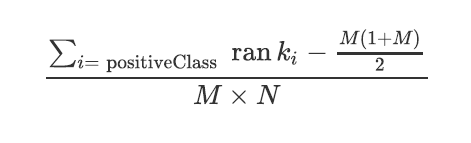

In [11]:
import pandas as pd

In [70]:
# 第三种方法计算AUC
def AUC_cal2(poresult,neresult):
    sum_ = 0 # 求和
    
    #生成DF 加标签
    poresult_df = pd.DataFrame(poresult,columns=['predict'])
    poresult_df['label'] = 1
    neresult_df = pd.DataFrame(neresult,columns=['predict'])
    neresult_df['label'] = 0
    
    # 合并
    df = pd.concat([poresult_df,neresult_df])
    df.reset_index(drop = True,inplace =True)
    
    #倒序排序
    df_sort = df.sort_values(by='predict',ascending=False)
    df_sort.index = [i for i in range(len(df_sort))][::-1] # 重新设置索引
    
    # 根据公式计算标签为正的索引
    for i in df_sort.index:
        if df_sort.loc[i,'label'] == 1:
            sum_ += int(i)
    return ((sum_ - len(poresult)*(1+len(poresult))/2) / (len(poresult)*len(neresult)))

In [71]:
AUC_cal2(poresult,neresult)

0.6666666666666666

## 简答

小韩和小李是一家互联网公司的实习生，他们刚入职就接受了一项任务，用机器学习的方法来预测某个行业query和广告之间的点击率。该模型将会用于对广告展现时，根据点击率，对展现的广告做重排序。他们两个都采用了LR方法来解决问题，具体的做法是：

（1）根据一个月该行业的日志，找到每次搜索时，当时展现的所有广告（一次展现固定出三条广告）。他们把每个广告的每次展现当作样本，当时是否点击为LR的y值：0或者1。这样一共获得了50w个样本（比如在一次搜索queryA下展现了三条广告a，b，c，其实a被点击了一次，那么这次搜索一共对应3个样本，其中第一个样本的y为1，后面两个样本的y为0）

（2）对样本做均匀抽样分成两份，70%为训练样本，30%为测试样本，抽取了100种特征，其中一个特征是当时广告在网页中的排序（1，2或者3）

（3）使用公司的LR在训练样本上进行训练，在测试样本中进行检测， 认为LR模型给出的p即为广告的点击率，其中  

a.对于广告在网页中的排序，小韩使用的方法是离散乘0-1特征，即将排序离散成（是否为第一名，是否为第二名，是否为第三名），如果样本的排序是第一名，对应的特征为（1,0,0），如果样本的排序为第二名，对应的特征为（0,1,0），而小李的方法是直接对排序做归一后当作特征的取值，如第一名为0，第二名为0.5，第三名为1，问他们谁的方法效果会更好，为什么？

答：小李效果会更好。特征 [广告在网页中的排序] 是一个有序特征，故而使用 0，1，2序列能够更好的表示特征

b.一般大型LR模型都是使用随机梯度下降的方式，所以需要选择初始值，小韩把beta()的初始值设置成了广告的平均点击0.01，而小李把bata()设置为1，问在实际线上应用的时候，他们谁的方法效果会更好，为什么？

答：小韩效果会更好。融入先验，加快收敛精度和速度。

c.在直接使用LR模型的时候($loss=\sum yilog(h(x))+(1-yi)log(1-h(x)))h(x）=1/(1+exp(-xi*thetai)$),小韩和小李发现在训练样本中拟合的很好，但是在测试样本中效果比较差，问可能是什么原因导致？怎么解决？

答：出现了过拟合。建议考虑调整正则参数，或考虑多重线性回归。

d.在测试的时候，他们使用auc来评估效果，请问auc是怎么计算的？

1) 第一种方法：AUC为ROC曲线下的面积，那我们直接计算面积可得。面积为一个个小的梯形面积之和，计算的精度与阈值的精度。  
2) 第二种方法：根据AUC的物理意义，我们计算正样本score大于负样本的score的概率。取MN（M为正样本数，N为负样本数）个二元组，比较score，最后得到AUC。时间复杂度为O(MN)。  
3) 第三种方法：与第二种方法相似，直接计算正样本score大于负样本的score的概率。我们首先把所有样本按照score排序，依次用rank表示他们，如最大score的样本，rank=n(n=M+N)，其次为n-1。那么对于正样本中rank最大的样本（rank_max），有M-1个其他正样本比他score小，那么就有(rank_max-1)-(M-1)个负样本比他score小。其次为(rank_second-1)-(M-2)。最后我们得到正样本大于负样本的概率。